<a href="https://colab.research.google.com/github/RLWH/tensorflow-certification-labs/blob/main/C2_W3_Lab_1_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Transfer Learning
In this lab, we will see how to use a pre-trained model to achieve good results even with a small training dataset. This is called *transfer learning* and we do this by leveraging the trained layers of an existing model and adding our own layers to fit the application. 

For example, we can:
1. Just get the convoluation layers of one model
2. Attach some dense layers onto it
3. Train just the dense network
4. Evaluate the results

Doing this will allow us to save time building our application because we will essentially skip weeks of training time of very deep networks. We will just use the features it has learned and tweak it for the dataset. 

# Setup the pretrained model
We will need to prepare pretrained model and configure the layers that we need. 

For this exercise, we will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as our base model. To do that, we need to: 

1. Set the input shape to fit our application. In this case, set it to `150x150x3` as we have been doing in the last few labs
2. Pick and freeze the convolution layers to take advantage of the features it has learned already. 
3. Add dense layers which we will train


First, in preparing the input to the model, we want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because we will be replacing it later. 

We will also specify the input shape that our model will accept. 

Lastly, we want to freeze the weights of these layers because they have been trained alredy. 

In [1]:
# Download the pre-trained weights. No top means it excludes the fully conected layer. 
!!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

['--2022-12-03 03:02:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 87910968 (84M) [application/x-hdf]',
 'Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’',
 '',
 '',
 '          /tmp/ince   0%[                    ]       0  --.-KB/s               ',
 '         /tmp/incep   0%[                    ] 112.20K   536KB/s               ',
 '        /tmp/incept   0%[                    ] 560.20K  1.33MB/s               ',
 '       /tmp/incepti   3%[                    ]   2.55M  4.17MB/s               ',
 '      /tmp/inceptio  11%[=>                  ]   9.74M  12.0MB/s               ',
 '     /tmp/inception  18%[==>            

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file we downloaded into a variable
local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Initialise the base model
# Set the input shape and remove the dense layers
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

# Load the pre-trained weights we downloaded
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

![InceptionV3 Architecture](https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png)

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

So this is the summary of the model. We can see that it is a very deep network. 

We can then select up to which point of the network we want to use.

For this exercise, we will use up to `mixed_7` as our base model and add to that. This is because the original last layer might be too specialised in what it has learned so it might not translate well into the application. 

`mixed_7`, on the other hand, will be more generalised and we can start with that for our application. 

After the exercise, we can also experiment on other layers. 

In [4]:
# Choose `mixed_7` as the last layer of the base model
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


# Add dense layers for classifier
Next, we will add dense layers to our model. These will be the layers that we will train and is taked to recognising cats and dogs. 

We will also add a `Dropout` layer to regularise the output and avoid overfitting. 

In [5]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model


# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [6]:
# Set the training parameters
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Prepare the dataset

Now, we will prepare the dataset. This is basically the same code as the one we used in the data augmentation lab. 

In [7]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-12-03 03:28:18--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  21.0MB/s    in 3.1s    

2022-12-03 03:28:21 (21.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
# Preprocessing
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Train the model
We will train 20 epochs and plot the results afterwards

In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 122s - loss: 0.3508 - accuracy: 0.8620 - val_loss: 0.1141 - val_accuracy: 0.9530 - 122s/epoch - 1s/step
Epoch 2/20
100/100 - 110s - loss: 0.2095 - accuracy: 0.9110 - val_loss: 0.1426 - val_accuracy: 0.9520 - 110s/epoch - 1s/step
Epoch 3/20
100/100 - 110s - loss: 0.1802 - accuracy: 0.9390 - val_loss: 0.1591 - val_accuracy: 0.9510 - 110s/epoch - 1s/step
Epoch 4/20
100/100 - 109s - loss: 0.2077 - accuracy: 0.9285 - val_loss: 0.1564 - val_accuracy: 0.9520 - 109s/epoch - 1s/step
Epoch 5/20
100/100 - 109s - loss: 0.1981 - accuracy: 0.9325 - val_loss: 0.1044 - val_accuracy: 0.9590 - 109s/epoch - 1s/step
Epoch 6/20
100/100 - 106s - loss: 0.1609 - accuracy: 0.9455 - val_loss: 0.0814 - val_accuracy: 0.9660 - 106s/epoch - 1s/step
Epoch 7/20
100/100 - 112s - loss: 0.1837 - accuracy: 0.9350 - val_loss: 0.1072 - val_accuracy: 0.9650 - 112s/epoch - 1s/step
Epoch 8/20
100/100 - 120s - loss: 0.1673 - accuracy: 0.9470 - val_loss: 0.1150 - val_accuracy: 0.9670 - 120s/epoch - 1s/step


# Evaluate the result


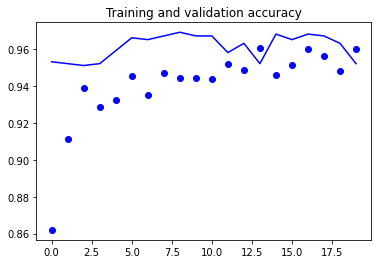

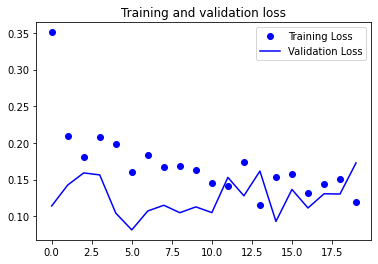

In [10]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Plot training results
plot_loss_acc(history)